# 线性支持向量机的朴素实现

+ 虽然从形式上来说，线性支持向量机（LinearSVM）和感知机的差别只在于损失函数，但如果只是简单地将感知机的训练策略（亦即每次只选出使得损失函数最大的样本点来进行梯度下降）迁移过来的话、会引发一些问题。为方便，我们称感知机的训练策略为`极大梯度下降法`（注：这不是被广泛承认的称谓，只是本文的一个代称）
+ 我会先使用极大梯度下降的方法来实现SVM,展示极大梯度下降法的有效性，然后会通过SMO方法进行展示,并进行两种算法的对比.

## 数据集
由于找到的的数据为中日两国的主要城市的经纬度坐标,其中有部分数据有问题,再次进行了手动以及自动筛选的办法,从中选取了少量的数据来进行验证算法的正确性以及效率.

**原始数据集**
蓝色圆圈为中国城市.红色五角星为日本城市,绿色十字为钓鱼岛.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.random as rnd
import copy

(18254, 2)


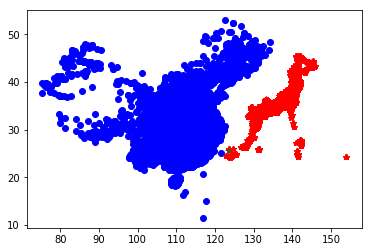

In [2]:
x = np.loadtxt("cities_all.csv", delimiter=',', skiprows=1, usecols=(1, 2))
y = np.loadtxt("cities_all.csv", delimiter=',', skiprows=1, usecols=(3))
print(x.shape)
plt.plot(x[y == 1][:,0], x[y == 1][:,1],'bo')
plt.plot(x[y == -1][:,0], x[y == -1][:,1],'r*')
plt.plot(x[y == 0][:,0], x[y == 0][:,1],'g+')
plt.show()

**清洗过后的数据**观察发现原始数据集过于庞大并且不满足对于沿海城市条件.故进行了筛选,优先选择沿海城市,并进行了随机抽样.

In [3]:
def genData():
    X = np.loadtxt("cities_small.csv", delimiter=',', skiprows=1, usecols=(1, 2))
    Y = np.loadtxt("cities_small.csv", delimiter=',', skiprows=1, usecols=(3))
    
    rnd.seed(0)
    sample1 = rnd.choice(X[Y == 1].shape[0],300)
    sample2 = rnd.choice(X[Y == -1].shape[0],300) + X[Y == 1].shape[0]
    sample = np.concatenate(([0,],np.concatenate((sample1,sample2))))
    X = X[sample].copy()
    Y= Y[sample].copy()
    
    return X,Y


(601, 2)


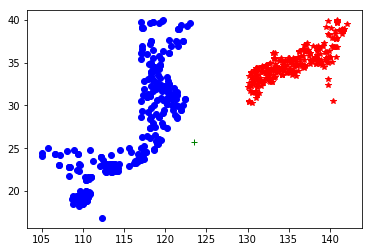

In [4]:
x, y = genData()
print(x.shape)
plt.plot(x[y == 1][:,0], x[y == 1][:,1],'bo')
plt.plot(x[y == -1][:,0], x[y == -1][:,1],'r*')
plt.plot(x[y == 0][:,0], x[y == 0][:,1],'g+')

## 极大梯度下降法训练 LinearSVM

In [5]:
class LinearSVM:
    def __init__(self):
        self._w = self._b = None
        
    def fit(self, x, y, c=1, lr=0.01, epoch=10000):
        x, y = np.asarray(x, np.float32), np.asarray(y, np.float32)
        self._w = np.zeros(x.shape[1])
        self._b = 0.
        for _ in range(epoch):
            self._w *= 1 - lr
            err = 1 - y * self.predict(x, True)
            idx = np.argmax(err)
            # 注意即使所有 x, y 都满足 w·x + b >= 1
            # 由于损失里面有一个 w 的模长平方
            # 所以仍然不能终止训练，只能截断当前的梯度下降
            if err[idx] <= 0:
                continue
            delta = lr * c * y[idx]
            self._w += delta * x[idx]
            self._b += delta
    
    def predict(self, x, raw=False):
        x = np.asarray(x, np.float32)
        y_pred = x.dot(self._w) + self._b
        if raw:
            return y_pred
        return np.sign(y_pred).astype(np.float32)
    
    def genPlt(self, X, Y, plt):
        plt.plot(X[Y == 1][:,0], X[Y == 1][:,1],'bo')
        plt.plot(X[Y == -1][:,0], X[Y == -1][:,1],'r*')
        plt.plot(X[Y == 0][:,0], X[Y == 0][:,1],'g+')
        
        
        ly = np.linspace(x[:,1].min(),x[:,1].max())
        lx = -(self._b + self._w[1] * ly)/self._w[0]

        plt.plot(lx,ly)
        return plt
        

#### 对清洗过后的数据不进行任何处理直接进行训练:

准确率：0.166389 %


/home/toby/miniconda3/envs/MLDL/lib/python3.5/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


<module 'matplotlib.pyplot' from '/home/toby/miniconda3/envs/MLDL/lib/python3.5/site-packages/matplotlib/pyplot.py'>

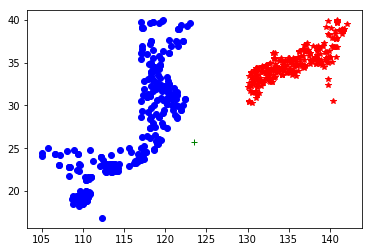

In [6]:
svm = LinearSVM()
svm.fit(x, y)
print("准确率：{:8.6} %".format((svm.predict(x) == y).mean() * 100))
svm.genPlt(x,y,plt)

发现上图由于经纬度取值都较大,所以训练出来的分类面无法进行正确的分类.

通过进行归一化处理再次进行训练:

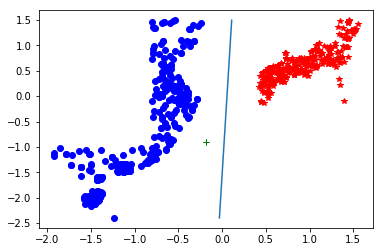

In [7]:
# 进行归一化处理
x -= x.mean(axis=0)
x /= x.std(axis=0)
# Top 1 梯度下降法即为极大梯度下降法
top_1_svm = LinearSVM()
top_1_svm.fit(x[1:], y[1:])
top_1_svm.genPlt(x,y,plt)

plt.plot(x[0][0], x[0][1],'g+')
plt.show()

## SMO算法

In [8]:
class SVMStruct:

    def __init__(self, x, y, C, Toler, kernelType):
        self.x = x  # 数据样本,每一行代表一个样本
        self.y = y  # 分类标签
        self.b = 0
        self.C = C  # C是离群点的权重，C越大表明离群点对目标函数影响越大，也就是越不希望看到离群点
        self.Toler = Toler  # 松弛变量
        self.numSamples = x.shape[0]    # 样本个数
        self.alphas = np.mat(np.zeros((self.numSamples, 1)))  # 所有样本的拉格朗日因子
        self.errorCache = np.mat(np.zeros((self.numSamples, 2)))  # 每次迭代的误差
        # 核函数类型
        # kernelType=("rbf", 1) rbf 表示使用径向基RBF函数作为核函数,其第二个参数不可为0
        # kernelType=("linear", 0) rbf 表示使用径向基RBF函数作为核函数,不会使用到第二个参数
        self.kernelType = kernelType
        # 计算x矩阵的核函数矩阵
        self.kernelMat = calcKernelMatrix(x, kernelType)


def calcKernelMatrix(x, kernelType):
    # 计算x矩阵的核函数矩阵
    n = x.shape[0]
    kernelMat = np.mat(np.zeros((n, n)))
    for i in range(n):
        kernelMat[:, i] = calcKernelValue(x, x[i, :], kernelType, n)
    return kernelMat


def calcKernelValue(x, xi, kernelType, n):
    # 根据选择的情况计算核函数矩阵
    kernelValue = np.mat(np.zeros((n, 1)))
    if kernelType[0] == "linear":
        kernelValue = x * xi.T
    elif kernelType[0] == "rbf":
        for i in range(n):
            diff = x[i, :] - xi
            kernelValue[i] = np.exp(diff * diff.T / (-2.0 * kernelType[1]**2))
    else:
        # 通过raise显示地引发异常。一旦执行了raise语句，raise后面的语句将不能执行
        raise NameError('请选择核函数的类型')
    return kernelValue


def SVMtrain(x, y, C, Toler, IterNum, kernelType):
    model = SVMStruct(x, y, C, Toler, kernelType)
    # 记录迭代结束后实际迭代次数
    iterCount = 0
    # 判断α的值是否发生了变化
    ischange = 1
    # 开始迭代,终止条件为：
    # 1、完成所有迭代
    # 2、α的值不再发生变化并且所有α(样本)符合KKT条件
    while(iterCount < IterNum and ischange > 0):
        ischange = 0
        for i in range(model.numSamples):
            ischange += innerLoop(model, i)
        iterCount += 1
    print(iterCount)

    return model


def innerLoop(model, i):
    Ei = calcError(model, i)
    # 判断该点是否符合KKT条件，符合就返回0.不符合进行更新
    if(FitKKT(model, i) == 0):
        return 0
    # 根据αi选择αj
    j, Ej = selectAlpha(model, i, Ei)
    # Python中的赋值操作（包括对象作为参数、返回值）不会开辟新的内存空间，它只是复制了新对象的引用
    # 浅拷贝会创建新对象，其内容是原对象的引用。浅拷贝有三种形式：切片操作，工厂函数，copy模块中的copy函数
    # 深拷贝拷贝了对象的所有元素，包括多层嵌套的元素
    alpha_i_old = copy.deepcopy(model.alphas[i])
    alpha_j_old = copy.deepcopy(model.alphas[j])
    # 计算边界L和H
    # if yi!=yj L=max(0,αj-αi) H=min(C,C+αj-αi)
    # if yi==yj L=max(0,αj+αi-C) H=min(C,αj+αi)
    if(model.y[i] != model.y[j]):
        L = max(0, model.alphas[j] - model.alphas[i])
        H = min(model.C, model.C + model.alphas[j] - model.alphas[i])
    else:
        L = max(0, model.alphas[j] + model.alphas[i] - model.C)
        H = min(model.C, model.alphas[j] + model.alphas[i])
    if L == H:
        return 0
    # 计算样本i和j之间的相似性
    ETA = 2.0 * model.kernelMat[i, j] - \
        model.kernelMat[i, i] - model.kernelMat[j, j]
    if ETA >= 0:
        return 0
    # 更新αj
    model.alphas[j] -= model.y[j] * (Ei - Ej) / ETA
    # αj必须在边界内，因此在计算出新的αj后要对其进行新的裁剪
    # if αj>H then αj=H
    # if L<=αj<=H then αj=αj
    # if αj>H then αj=H
    if(model.alphas[j] > H):
        model.alphas[j] = H
    if(model.alphas[j] < L):
        model.alphas[j] = L
    # 如果本次更新几乎没有变化就返回
    if abs(alpha_j_old - model.alphas[j]) < 0.00001:
        return 0
    # 更新αi  αi=αi+yi*yj*(aj_old-aj)
    model.alphas[i] += model.y[i] * model.y[j] * \
        (alpha_j_old - model.alphas[j])
    # 更新阀值b
    # b1=b-Ei-yi(αi-αi_old)<xi,xi>-yj(αj-αj_old)<xi,xj>
    # b2=b-Ej-yi(αi-αi_old)<xi,xj>-yj(αj-αj_old)<xj,xj>
    b1 = model.b - Ei - model.y[i] * (model.alphas[i] - alpha_i_old) * model.kernelMat[
        i, i] - model.y[j] * (model.alphas[j] - alpha_j_old) * model.kernelMat[i, j]
    b2 = model.b - Ej - model.y[i] * (model.alphas[i] - alpha_i_old) * model.kernelMat[
        i, j] - model.y[j] * (model.alphas[j] - alpha_j_old) * model.kernelMat[j, j]
    # if 0<αi<C then b=b1
    # if 0<αj<C then b=b2
    # if other then b=(b1+b2)/2
    if (0 < model.alphas[i]) and (model.alphas[i] < model.C):
        model.b = b1
    elif (0 < model.alphas[j]) and (model.alphas[j] < model.C):
        model.b = b2
    else:
        model.b = (b1 + b2) / 2.0
    updateError(model, i)
    updateError(model, j)
    return 1


def updateError(model, j):
    E = calcError(model, j)
    model.errorCache[j] = [1, E]


def selectAlpha(model, i, Ei):
    rnd.seed(0)
    # [1, Ei] 1表示已经被优化
    model.errorCache[i] = [1, Ei]
    # nonzero()将布尔数组转换成整数数组
    # nonzero(x)返回x集合中为True的元素下标集合
    # 用于找出所有符合KKT条件的乘子的E
    Alphalist = np.nonzero(model.errorCache[:, 0].A)[0]
    maxStep = 0
    j = 0
    Ej = 0
    # 选择误差步长最大的最为αj
    if(len(Alphalist) > 1):
        # k 不能等于i和j
        for k in Alphalist:
            if k == i:
                continue
            Ek = calcError(model, k)
            if abs(Ek - Ei) > maxStep:
                maxStep = abs(Ek - Ei)
                j = k
                Ej = Ek
    # 如果是第一次 随机选择αj
    else:
        j = i
        while j == i:
            j = rnd.randint(0, model.numSamples - 1)
        Ej = calcError(model, j)
    return j, Ej


def calcError(model, i):
    f = np.multiply(model.alphas, model.y).T * model.kernelMat[:, i] + model.b
    return (f - model.y[i])


def FitKKT(model, i):
    E = calcError(model, i)
    # 约束条件1：0<=α<=C
    # 约束条件2：必须满足KKT条件
    #     1-1、if yf>=1 then α==0
    #     1-2、if yf<=1 then α==C
    #     1-3、if yf==1 then 0<α<C
    #     因此可以得到不满足KKT的条件
    #     2-1、if yf>=1 then α>0
    #     2-2、if yf<=1 then α<C
    #     2-3、if yf==1 then α==0 or α==C
    #     仔细考虑2-1，当yf=1 then α>0,符合1-3
    #     仔细考虑2-1，当yf=1 then α<C,符合1-3
    #     仔细考虑2-3，符合1-1和1-2
    #     因此得到：
    #     3-1、if yf>1 then α>0
    #     3-2、if yf<1 then α<C
    #     预测值与真实值之差 E=f-y
    #     yE=yf-yy because y∈(-1,1) so yE=fy-1
    #     4-1、if yE>0 then α>0
    #     4-2、if yE<0 then α<C
    #     我们在这里加入一个松弛变量Toler：
    #     1、if yE>Toler then α>0
    #     2、if yE<-Toler then α<C
    if((model.y[i] * E < -Toler and model.alphas[i] < model.C)
       or (model.y[i] * E > Toler and model.alphas[i] > 0)):
        return 1
    else:
        return 0


def SVMPredict(model, x, y):
    n = x.shape[0]
    # 加入核函数之后，新的fx=yi*ai*k<x,xi>+b
    # 又因为alphas大多数都为0，因此值用计算不为0的就可以
    supportVectorsIndex = np.nonzero(
        (model.alphas.A > 0) * (model.alphas.A < model.C))[0]
    supportVectors = model.x[supportVectorsIndex]
    supportVectorLabels = model.y[supportVectorsIndex]
    supportVectorAlphas = model.alphas[supportVectorsIndex]
    matchCount = 0
    for i in range(n):
        kernelValue = calcKernelValue(
            supportVectors, x[i, :], model.kernelType, n)
        predict = kernelValue.T * \
            np.multiply(supportVectorLabels, supportVectorAlphas) + model.b
        if np.sign(predict) == np.sign(y[i]):
            matchCount += 1
    accuracy = float(matchCount) / n
    return accuracy


def Draw(model):
    # 画出所有的点
    for i in range(model.numSamples):
        if model.y[i] == -1:
            plt.plot(model.x[i, 0], model.x[i, 1], 'or')
        elif model.y[i] == 1:
            plt.plot(model.x[i, 0], model.x[i, 1], 'ob')
    # 计算支持向量
    supportVectorsIndex = np.nonzero(
        (model.alphas.A > 0) * (model.alphas.A < model.C))[0]

    # 画出分类线
    w = np.zeros((2, 1))
    # 求wi=yi*ai*xi i=0,1,2...n
    for i in supportVectorsIndex:
        w += np.multiply(model.alphas[i] * model.y[i], model.x[i, :].T)
    min_x = min(model.x[:, 0])[0, 0]
    max_x = max(model.x[:, 0])[0, 0]
    y_min_x = float(-model.b - w[0] * min_x) / w[1]
    y_max_x = float(-model.b - w[0] * max_x) / w[1]
    plt.plot([min_x, max_x], [y_min_x, y_max_x], '-g')
    
    return plt
   

**设置模型参数,并生成需要的数据:**

In [9]:
# 设置模型参数
C = 0.6
IterNum = 20
Toler = 0.001
x, y = genData()
# 分理出钓鱼岛的数据
p_x = x[y==0]
p_y = y[y==0]
p_x = np.mat(p_x)
p_y = np.mat(p_y).T
# 分离出正常的训练数据集
x = x[y!=0]
y = y[y!=0]
x = np.mat(x)
y = np.mat(y).T

**训练模型并对钓鱼岛进行预测:**

2
0.0


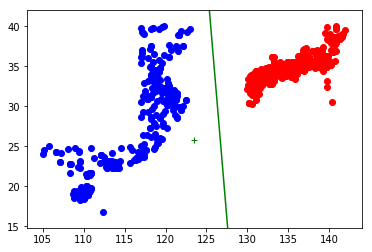

In [10]:
# 训练模型
model = SVMtrain(x, y, C, Toler, IterNum, kernelType=("linear", 1))

# # 测试数据
predict = SVMPredict(model, p_x, p_y)
print(predict)
# # 数据展示
plt = Draw(model)
plt.xlim(x[:,0].min()-2,x[:,0].max()+2)
plt.ylim(x[:,1].min()-2,x[:,1].max()+2)
plt.plot(p_x[0,0],p_x[0,1],'g+')
plt.show()

## 总结

通过观察两种方法所绘制的图像可以发现,采用梯度下降的方法时,数据的scale很大时,分类器不能很好的工作,通过对于数据的归一化处理,将数据scale变小,在运用SVM模型的时候,可以进行较好的分类预测.
如果采用SMO算法,观察发现,虽然在和算法的实现上较为复杂,但是对于scale较大的数据仍然能够很好的适应,并进行分类预测.

对于预测钓鱼岛的归属问题,两种方法在该数据集上都能做出钓鱼岛数据中国的预测.